In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib


In [3]:
# Load housing data
df_raw = pd.read_csv("melbourne_housing_cleaned (2).csv")
print(df_raw.shape)
df_raw.head()


(175, 11)


,suburb,address_display,property_type,bedrooms,bathrooms,car_spaces,land_size_sqm,sold_price_display,sale_date,agent,url
0,Essendon,"10/332 Pascoe Vale Road, Essendon",Apartment,2,1,1.0,NaN,"$360,000",25/07/2025,Tom Donnelley,https://www.realestate.com.au/sold/property-ap...
1,Essendon,"8/225 Buckley Street, Essendon",Apartment,2,1,1.0,NaN,"$427,500",24/07/2025,Luke Swannie,https://www.realestate.com.au/sold/property-ap...
2,Essendon,"320/1044-1046 Mt Alexander Road, Essendon",Apartment,2,1,2.0,NaN,"$400,000",23/07/2025,Suzy Pavlov,https://www.realestate.com.au/sold/property-ap...
3,Essendon,"53 Deakin Street, Essendon",House,3,2,2.0,755.0,"$1,920,000",22/07/2025,Lara Harris,https://www.realestate.com.au/sold/property-ho...
4,Essendon,"24 Violet Street, Essendon",House,2,1,2.0,300.0,"$1,020,000",18/07/2025,Julia Murphy,https://www.realestate.com.au/sold/property-ho...


In [ ]:
# --- Data Cleaning ---

df = df_raw.copy()

# Convert sold_price_display → numeric sold_price
df["sold_price"] = (
    df["sold_price_display"]
    .replace(r"[\$,]", "", regex=True)
    .astype(float)
)


date_col = "sale_date_iso" if "sale_date_iso" in df.columns else "sale_date"


use_cols = ["suburb", "property_type", "agent", "bedrooms", "bathrooms",
            "car_spaces", "land_size_sqm", "sold_price", date_col]
df = df[[c for c in use_cols if c in df.columns]]

# Fix numeric values
df["car_spaces"] = pd.to_numeric(df["car_spaces"], errors="coerce")
df["land_size_sqm"] = pd.to_numeric(df["land_size_sqm"], errors="coerce")

# Fill missing values
df["car_spaces"] = df["car_spaces"].fillna(df["car_spaces"].median())
df["land_size_sqm"] = df["land_size_sqm"].fillna(df["land_size_sqm"].median())
df["agent"] = df["agent"].fillna("Unknown")

# Parse date
df["sale_date"] = pd.to_datetime(df[date_col], errors="coerce")

# Drop rows missing critical values
df = df.dropna(subset=["suburb", "property_type", "sold_price", "sale_date"])

print("Missing values:\n", df.isna().sum())
df.head()


Missing values:
 suburb           0
property_type    0
agent            0
bedrooms         0
bathrooms        0
car_spaces       0
land_size_sqm    0
sold_price       0
sale_date        0
dtype: int64


C:\Users\gpran\AppData\Local\Temp\ipykernel_34928\2664513085.py:30: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["sale_date"] = pd.to_datetime(df[date_col], errors="coerce")


,suburb,property_type,agent,bedrooms,bathrooms,car_spaces,land_size_sqm,sold_price,sale_date
0,Essendon,Apartment,Tom Donnelley,2,1,1.0,567.0,360000.0,2025-07-25
1,Essendon,Apartment,Luke Swannie,2,1,1.0,567.0,427500.0,2025-07-24
2,Essendon,Apartment,Suzy Pavlov,2,1,2.0,567.0,400000.0,2025-07-23
3,Essendon,House,Lara Harris,3,2,2.0,755.0,1920000.0,2025-07-22
4,Essendon,House,Julia Murphy,2,1,2.0,300.0,1020000.0,2025-07-18


In [6]:
# Extract date features
df["sale_year"] = df["sale_date"].dt.year
df["sale_month"] = df["sale_date"].dt.month

# Derived features
df["rooms_total"] = df["bedrooms"] + df["bathrooms"]
df["density_bed_per_100sqm"] = np.where(
    df["land_size_sqm"] > 0,
    df["bedrooms"] / (df["land_size_sqm"] / 100),
    0
)

# Binary flags
df["is_house"] = df["property_type"].str.lower().str.contains("house").astype(int)
df["is_apartment"] = df["property_type"].str.lower().str.contains("apart|unit").astype(int)

df.head()


,suburb,property_type,agent,bedrooms,bathrooms,car_spaces,land_size_sqm,sold_price,sale_date,sale_year,sale_month,rooms_total,density_bed_per_100sqm,is_house,is_apartment
0,Essendon,Apartment,Tom Donnelley,2,1,1.0,567.0,360000.0,2025-07-25,2025,7,3,0.352734,0,1
1,Essendon,Apartment,Luke Swannie,2,1,1.0,567.0,427500.0,2025-07-24,2025,7,3,0.352734,0,1
2,Essendon,Apartment,Suzy Pavlov,2,1,2.0,567.0,400000.0,2025-07-23,2025,7,3,0.352734,0,1
3,Essendon,House,Lara Harris,3,2,2.0,755.0,1920000.0,2025-07-22,2025,7,5,0.397351,1,0
4,Essendon,House,Julia Murphy,2,1,2.0,300.0,1020000.0,2025-07-18,2025,7,3,0.666667,1,0


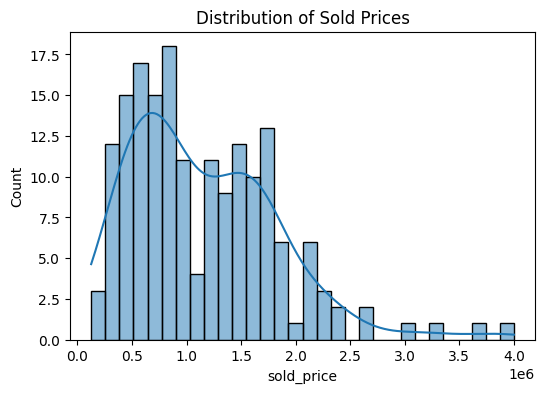

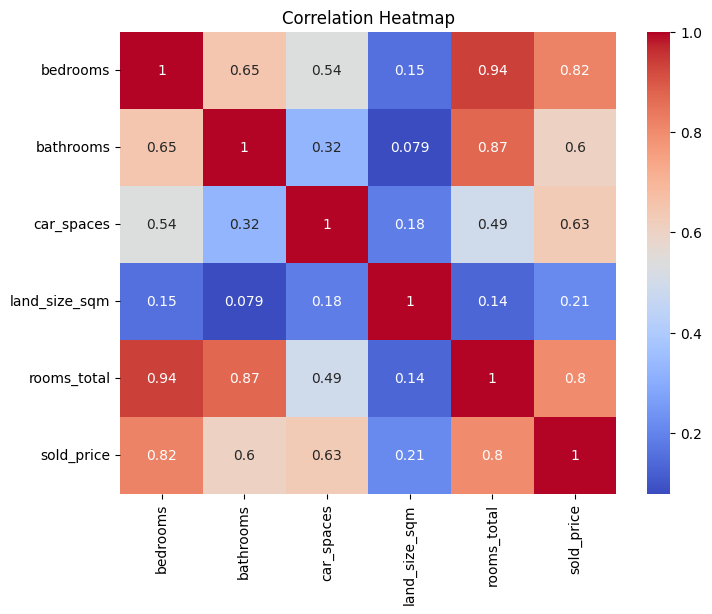

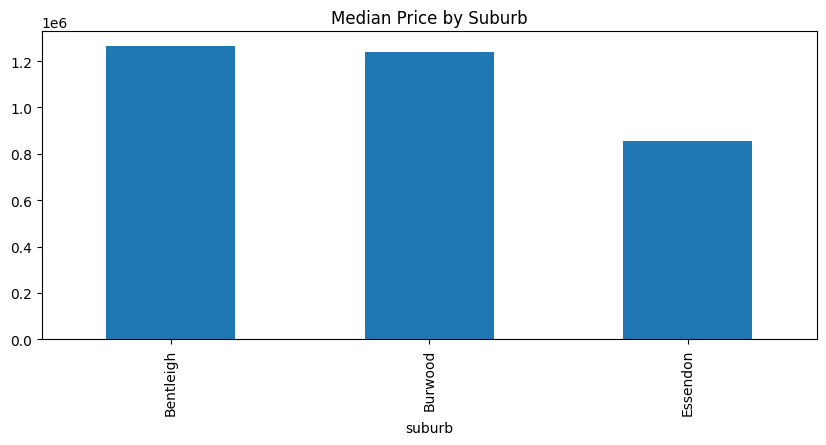

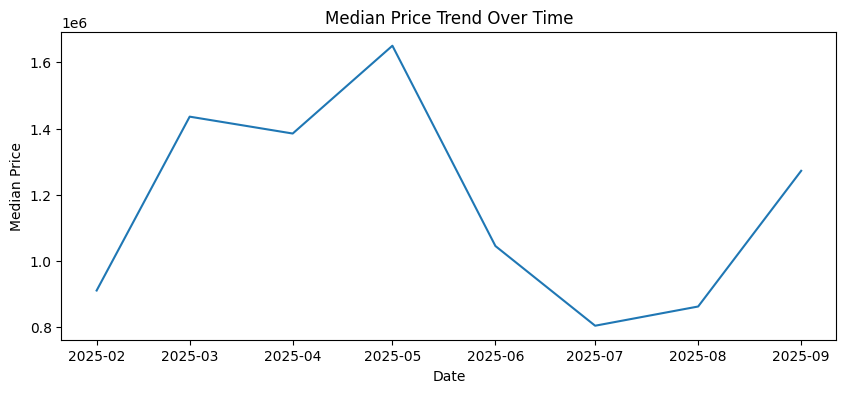

In [7]:
# Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df["sold_price"], bins=30, kde=True)
plt.title("Distribution of Sold Prices")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[["bedrooms","bathrooms","car_spaces","land_size_sqm","rooms_total","sold_price"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Price by suburb (top 10)
plt.figure(figsize=(10,4))
df.groupby("suburb")["sold_price"].median().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Median Price by Suburb")
plt.show()

# Price trend over time
trend = df.groupby(df["sale_date"].dt.to_period("M"))["sold_price"].median().to_timestamp()
plt.figure(figsize=(10,4))
plt.plot(trend.index, trend.values)
plt.title("Median Price Trend Over Time")
plt.ylabel("Median Price")
plt.xlabel("Date")
plt.show()


In [8]:
target = "sold_price"
feature_cols = ["suburb","property_type","agent","bedrooms","bathrooms","car_spaces",
                "land_size_sqm","sale_year","sale_month","rooms_total","density_bed_per_100sqm",
                "is_house","is_apartment"]

X = df[feature_cols].copy()
y = df[target].copy()

cat_cols = ["suburb","property_type","agent"]
num_cols = [c for c in feature_cols if c not in cat_cols]

print("X shape:", X.shape, " y shape:", y.shape)


X shape: (174, 13)  y shape: (174,)


In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

def evaluate_model(name, model, X, y):
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    mae = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error").mean()
    mse = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_squared_error").mean()
    rmse = np.sqrt(mse)
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring="r2").mean()
    
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2}

results = []
for name, model in models.items():
    results.append(evaluate_model(name, model, X, y))

results_df = pd.DataFrame(results)
print(results_df)


               Model            MAE           RMSE        R²
0  Linear Regression  252723.376800  353603.233927  0.720489
1      Decision Tree  244211.030924  386885.075601  0.675879
2      Random Forest  198650.887491  315343.677524  0.783355


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_best = Pipeline([("prep", preprocessor),
                      ("model", RandomForestRegressor(n_estimators=200, random_state=42))])

pipe_best.fit(X_train, y_train)
y_pred = pipe_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Test MAE :", mae)
print("Test RMSE:", rmse)
print("Test R²  :", r2)


Test MAE : 181768.07733333335
Test RMSE: 334978.06398352067
Test R²  : 0.7521671418710281


Top 15 features:
bedrooms                   0.250805
property_type_House        0.228489
is_house                   0.150132
rooms_total                0.092525
land_size_sqm              0.039415
density_bed_per_100sqm     0.033199
bathrooms                  0.026241
agent_Sam Maley            0.024824
agent_George Korderas      0.018402
agent_Bonnie Shang         0.017114
car_spaces                 0.017074
sale_month                 0.014196
suburb_Burwood             0.013063
property_type_Apartment    0.011477
suburb_Essendon            0.008808
dtype: float64


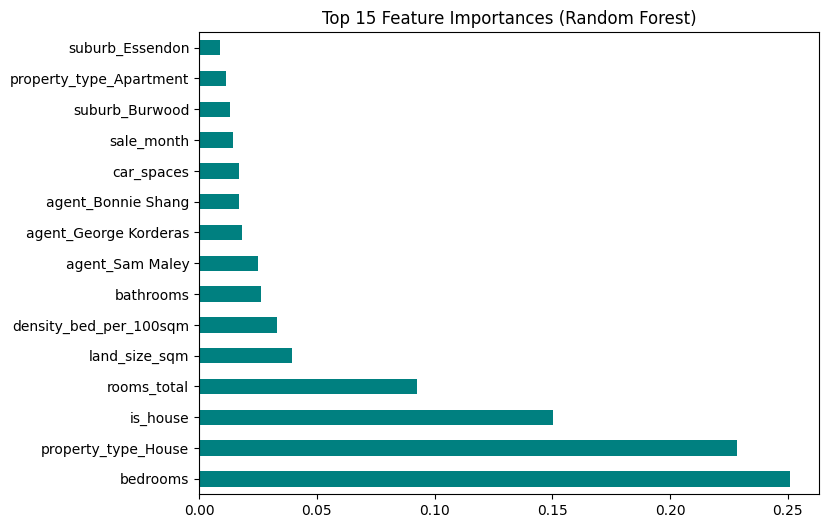

In [11]:
# Fit model on full dataset
pipe_best.fit(X, y)

ohe = pipe_best.named_steps["prep"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

importances = pipe_best.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

print("Top 15 features:")
print(feat_imp.head(15))

feat_imp.head(15).plot(kind="barh", figsize=(8,6), color="teal")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [12]:
joblib.dump(pipe_best, "melb_price_model.joblib")
print("✅ Model saved as melb_price_model.joblib")

sample = pd.DataFrame([{
    "suburb": "Essendon",
    "property_type": "House",
    "agent": "Unknown",
    "bedrooms": 3,
    "bathrooms": 2,
    "car_spaces": 2,
    "land_size_sqm": 400,
    "sale_year": 2025,
    "sale_month": 7,
    "rooms_total": 5,
    "density_bed_per_100sqm": 3/(400/100),
    "is_house": 1,
    "is_apartment": 0
}])

predicted_price = pipe_best.predict(sample)[0]
print(f"Predicted Price: ${predicted_price:,.0f}")


✅ Model saved as melb_price_model.joblib
Predicted Price: $1,493,068
